In [28]:
# On commence par importer les bibliothèques nécessaires
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

random.seed(10)

### Introduction

On étudie le dataset de feuilles d'arbres téléchargeable au lien suivant: https://www.kaggle.com/c/leaf-classification/data, ou sur le site d'Openclassrooms dans l'énoncé de cette activité.<br><br>
On n'utilise que le test d'entraînement proposé au téléchargement (Dataset_feuilles_1.csv) que l'on va diviser en un set de test et un set d'entraînement, car le set de test donné ne comprend pas la colonne target et ne permet donc pas d'évaluer un score. <br><br>
On souhaite entraîner un algorithme de machine learning afin de pouvoir catégoriser ces feuilles d'arbres par espèce d’arbre à partir de leur caractéristiques (essentiellement 3 vecteurs de dimension 64 - margin, shape & texture). <br><br>
L'objectif de cette activité est d'améliorer avec une SVM multi-classes le score de la baseline, c'est-à-dire le score obtenu en catégorisant les feuilles grâce à l'algorithme k_NN des plus proches voisins. 


### 1. Chargement, nettoyage et exploration préliminaire des données

On commence par charger les données dans une dataframe pandas.<br>
On sépare ensuite les données en un set d'entraînement et un set de test.<br>

In [29]:
# On charge les données
raw_set = pd.read_csv('Dataset_feuilles_1.csv')

# Exploration préliminaire
print(raw_set.shape)
#print(raw_set.head())

# On remplace la colonne species par un encodage sous forme d'entiers
labelencoder = LabelEncoder()
raw_set['species'] = labelencoder.fit_transform(raw_set['species'])

# NB : pour récupérer les libellés originaux, il faudra utiliser inverse_transform
#raw_set['species'] = labelencoder.inverse_transform(raw_set['species'])

# On sépare les features de la colonne target à prédire
# On retire la colonne 'id' qui n'est pas utile à la prédiction.
target = raw_set['species']
features = raw_set.drop(['species', 'id'], axis=1)

# On répartit les données en un set d'entraînement et un set de test. 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3)

# On normalise les features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(990, 194)


### 2. Baseline: k-NN
On choisit les paramètres du k-NN à appliquer avec une GridSearch sur les données d'entraînement.<br>
On fitte ensuite le modèle k-NN obtenu sur le set d'entraînement. <br>
On récupère le score de ce modèle sur le set de test: ce score est la baseline qu'il faut améliorer.

In [30]:
# A travers une Grid Search, on applique l'algorithme :
# - Pour toutes les valeurs du paramètre n entre 3 et 9 voisins. 
# - Pour deux manières d'attribuer des poids aux points lors du vote de la catégorie
# - Pour deux manières de calculer la distance entre les points.
# La meilleure combinaison sera choisie par cross-validation sur le set d'entraînement.
# On choisit comme métrique d'évaluation 'accuracy' (exactitude), 
# qui est la métrique par défaut pour les problèmes de classification. 

grid_params = {'n_neighbors' : range(3, 10),
               'weights'     : ['uniform', 'distance'],
               'metric'      : ['euclidean', 'manhattan']}

gs_knn = GridSearchCV(KNeighborsClassifier(), grid_params, 
                      scoring='accuracy', verbose=0, cv=3, iid=True)
gs_knn.fit(X_train, y_train)

knn = gs_knn.best_estimator_
knn_score = knn.score(X_test, y_test)

result_knn = '''
Le meilleur score par cross-validation sur le training set pour l'algorithme k-NN a été obtenu pour:
    - la métrique {0} pour calculer les distances entre points
    - {1} voisins
    - une pondération '{2}' du vote des points 
      NB : => 'distance' signifie que les points les plus distants comptent moins.
           => 'uniform' signifie que tous les voisins pris en compte ont une importance égale.
      
Le score de l'estimateur résultant sur le test set est de {3:5f}.
'''

print(result_knn.format(gs_knn.best_params_['metric'],
                        gs_knn.best_params_['n_neighbors'],
                        gs_knn.best_params_['weights'],
                        knn_score))


Le meilleur score par cross-validation sur le training set pour l'algorithme k-NN a été obtenu pour:
    - la métrique euclidean pour calculer les distances entre points
    - 3 voisins
    - une pondération 'distance' du vote des points 
      NB : => 'distance' signifie que les points les plus distants comptent moins.
           => 'uniform' signifie que tous les voisins pris en compte ont une importance égale.
      
Le score de l'estimateur résultant sur le test set est de 0.956229.



### 3. SVM multi-classes
On tente d'améliorer le score du k-NN avec une SVM multi-classes. 

In [34]:
grid_params = { 'C': np.logspace(-2, 2, 5),
                'multi_class' : ['ovr', 'crammer_singer'],
                'penalty' : ['l1', 'l2']  }

# Dans notre cas, il y a plus d'observations que de features
# On choisit donc de résoudre le problème primal (dual=False)
gs_svc = GridSearchCV(LinearSVC(dual=False, max_iter=2000),
                      grid_params, scoring='accuracy', verbose=3, 
                      cv=3, iid=True, n_jobs=-1)
gs_svc.fit(X_train, y_train)

svc = gs_svc.best_estimator_
svc_score = svc.score(X_test, y_test)

result_svc = '''
Le meilleur score par cross-validation sur le training set avec une SVM a été obtenu pour:
    - Un paramètre de régularisation C de {0}
    - La méthode multi-classes '{1}'
    - La norme {2}

Le score de l'estimateur résultant sur le test set est de {3:5f}.
'''

print(result_svc.format(gs_svc.best_params_['C'],
                        gs_svc.best_params_['multi_class'],
                        gs_svc.best_params_['penalty'],
                        svc_score))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.7min finished
/home/lea/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Le meilleur score par cross-validation sur le training set avec une SVM a été obtenu pour:
    - Un paramètre de régularisation C de 0.1
    - La méthode multi-classes 'crammer_singer'
    - La norme l1

Le score de l'estimateur résultant sur le test set est de 0.976431.



### 4. Visualisation des performances des deux modèles 
L'exactitude (accuracy) est le nombre de prédictions correctes divisé par le nombre de prédictions. Si l'on se fonde sur cette métrique, le modèle choisi est la SVM multi-classes, car son score est supérieur à celui du knn. <br><br>
On tente de visualiser ici un peu plus précisément les performances de chacun des deux modèles via une autre métrique: l'aire sous la courbe ROC. <br><br>
Le souci est que l'aire sous la courbe ROC convient plutôt aux classifieurs mono-classe. On considère donc, pour chaque classe du dataset, le problème mono-classe *"l'observation apartient-elle à l'espèce choisie, ou non?"*, et on évalue cette métrique pour ce problème. On en fait ensuite une moyenne sur toutes les classes. 

In [35]:
def get_auc_roc(clf, y_score, model):
     
    # Calcul de l'aire sous la courbe ROC pour chaque classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    thresholds = dict()
    classes = set(y_test)

    for i in classes:        
        
        # Aire sous la courbe ROC pour le problème:
        # "L'observation apartient-elle à l'espèce i ?""
        y_test_ = y_test == i
        y_test_ = y_test_.astype(int)
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_, y_score[:, i], drop_intermediate=False)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # On récupère la classe pour laquelle l'algorithme est le moins performant
    mini = min(roc_auc, key=roc_auc.get)
    
    # On fait la moyenne des scores obtenus
    roc_mean_ = np.mean(np.array(list(roc_auc.values())))
    
    result_ = (roc_mean_, fpr[mini], tpr[mini], roc_auc[mini], mini, model)
    return result_

clf_knn = OneVsRestClassifier(knn)
y_score_knn = clf_knn.fit(X_train, y_train).predict_proba(X_test)
result_knn = get_auc_roc(clf_knn, y_score_knn, 'knn')

clf_svc = OneVsRestClassifier(svc)
y_score_svc = clf_svc.fit(X_train, y_train).decision_function(X_test)
result_svc  = get_auc_roc(clf_svc, y_score_svc, 'svc')

result_roc = '''En moyenne sur toutes les classes:
- le score auc_roc obtenu via knn est de {0:5f}
- le score auc_roc obtenu via svc est de {1:5f}'''

print(result_roc.format(result_knn[0], result_svc[0]))

En moyenne sur toutes les classes:
- le score auc_roc obtenu via knn est de 0.989289
- le score auc_roc obtenu via svc est de 0.996420


La svc obtient donc un meilleur score que le knn pour la métrique roc_auc comme pour l'accuracy. 

Pour l'algorithme knn:
    - La pire prédiction est obtenue pour l'espèce Prunus_X_Shmittii. 
    - La courbe ROC correspondante est obtenue avec 3 paliers.


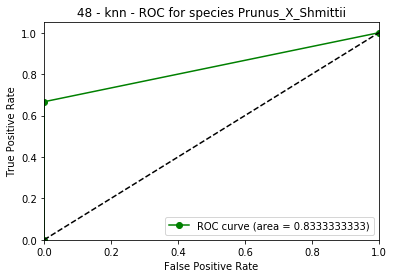

Pour l'algorithme svc:
    - La pire prédiction est obtenue pour l'espèce Prunus_X_Shmittii. 
    - La courbe ROC correspondante est obtenue avec 298 paliers.


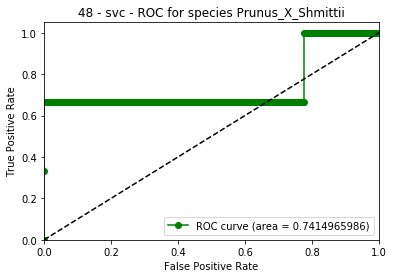

In [37]:
def visualization(result_):
    
    fpr = result_[1]
    tpr = result_[2]
    auc = result_[3]
    mini = result_[4]
    model = result_[5]
    
    specie = labelencoder.inverse_transform([mini])[0]
    
    worst = '''Pour l'algorithme {0}:
    - La pire prédiction est obtenue pour l'espèce {1}. 
    - La courbe ROC correspondante est obtenue avec {2} paliers.'''
    
    print(worst.format(model, specie, fpr.shape[0]))
    
    plt.figure()
    plt.plot(fpr, tpr, 'go-', label='ROC curve (area = %0.10f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title = '{0} - {1} - ROC for species {2}'.format(mini, model, specie)
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

visualization(result_knn)
visualization(result_svc)

Une remarque : l'aspect linéaire de la courbe ROC construite à partir de l'algorithme knn vient du faible nombre de paliers utilisés pour cet algorithme. <br><br>
Le faible nombre de paliers provient du fait qu'avec l'algorithme sélectionné et utilisé pour le problème mono-classe décrit plus haut, la probabilité qu'un point appartienne à la classe considérée ne peut prendre que n valeurs, car elle est calculée en ne tenant compte que des n voisins du point donné. 

### 5. Conclusion

En conclusion, et après évaluation des modèles svc et knn, on choisira le modèle svc dont le score est meilleur à la fois en termes d'accuracy et d'aire sous la courbe ROC.